# Module 4

In [1]:
import matplotlib.pyplot as plt
import imageio as img
import numpy as np
import pandas as pd
import scipy as sp
import skimage as ski #for different image analysis algorithms
import skimage.filters
import image_analysis as anl
import seaborn as sns; sns.set_style('white'); sns.set_context('notebook')

In [2]:
figfile = "Processed/"

# 4.1 Quantized Aggregates
## Bright Image

In [3]:
pic = np.array(img.imread('Images/emitters1_33px_bright_easy.png')).astype('double')

Get locations of every point source in the image.

In [4]:
loc_r = np.arange(32,np.shape(pic)[0],33)
loc_c = np.arange(32,np.shape(pic)[1],33)
locs = np.array(np.meshgrid(loc_r,loc_c)).T.reshape(-1,2)

In [5]:
print(np.shape(np.array(np.meshgrid(loc_r,loc_c))))

(2, 10, 10)


Zoom into a point source.

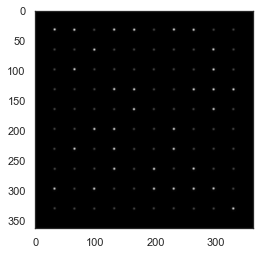

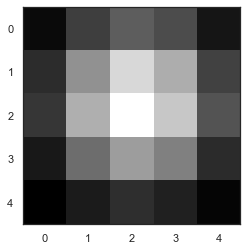

In [6]:
n = 0; wdth = 2
plt.imshow(pic, cmap = 'gray'); plt.show()
plt.imshow(pic[locs[n,0]-wdth:locs[n,0]+wdth+1, locs[n,1]-wdth:locs[n,1]+wdth+1], cmap = 'gray');

To figure out the brightness value of each point, it seems appropriate to average over a small region surrounding the pixel. Derive the mean value of each zoomed in pixel block as shown above and plot the histogram.

In [7]:
def quant_dist(pic,locs,wdth = 2,sub = False,stdev = 10):
    if sub == True:
        bkg = ski.filters.gaussian(pic,stdev)
        pic = pic-bkg
    signal = np.zeros(np.shape(locs)[0])
    for i,_ in enumerate(locs):
        signal[i] = np.mean(pic[locs[i,0]-wdth:locs[i,0]+wdth+1, locs[i,1]-wdth:locs[i,1]+wdth+1])
    signal = (signal/np.min(signal))
    sns.distplot(signal, hist = False, rug = True)
    plt.xlabel("Point Signal Normalized by the Minimum Value");

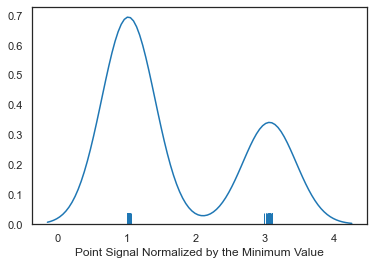

In [8]:
quant_dist(pic,locs)
plt.savefig(figfile+"quant_dist_bright_easy.png",dpi = 300)

The fluorescent molecule forms trimers.

## Dim Image

In [9]:
pic2 = np.array(img.imread('Images/emitters2_33px_dim_easy.png')).astype('double')

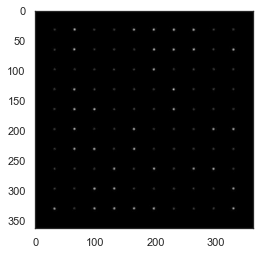

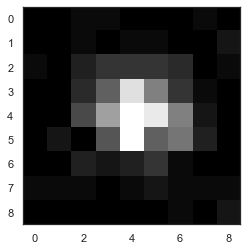

In [10]:
n = 0; wdth = 4
plt.imshow(pic2, cmap = 'gray'); plt.show()
plt.imshow(pic2[locs[n,0]-wdth:locs[n,0]+wdth+1, locs[n,1]-wdth:locs[n,1]+wdth+1], cmap = 'gray');

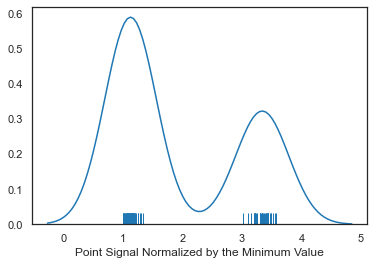

In [11]:
quant_dist(pic2,locs,wdth = 3)
plt.savefig(figfile+"quant_dist_dim_easy.png",dpi = 300)

Point signal is more variable, but the fluorescent molecule still seems to form a trimer.

## Bright Image with Variable Background

In [12]:
pic3 = np.array(img.imread('Images/emitters1_33px_bright_hard.png')).astype('double')

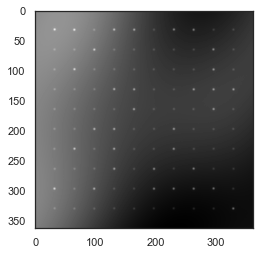

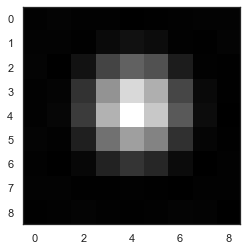

In [13]:
n = 0; wdth = 4
plt.imshow(pic3, cmap = 'gray'); plt.show()
plt.imshow(pic3[locs[n,0]-wdth:locs[n,0]+wdth+1, locs[n,1]-wdth:locs[n,1]+wdth+1], cmap = 'gray');

In this case, we need to perform background subtraction before taking the mean of the pixel block. First, obtain background by gaussian filtering.

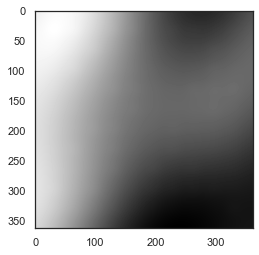

In [14]:
bkg = ski.filters.gaussian(pic3,10)
plt.imshow(bkg, cmap = 'gray'); plt.show()

Then subtract background from image.

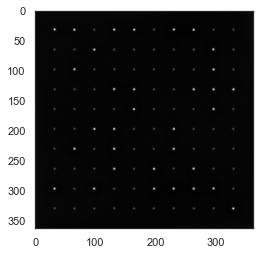

In [15]:
pic3_bkg_sub = pic3-bkg
plt.imshow(pic3_bkg_sub, cmap = 'gray'); plt.show()

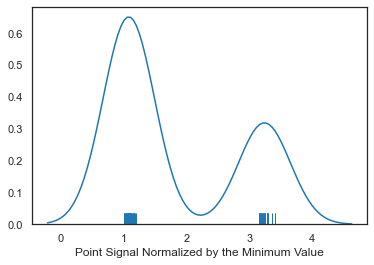

In [16]:
quant_dist(pic3_bkg_sub,locs,wdth = 3)
plt.savefig(figfile+"quant_dist_bright_hard.png",dpi = 300)

## Dim Image with Variable Background

In [17]:
pic4 = np.array(img.imread('Images/emitters2_33px_dim_hard.png')).astype('double')

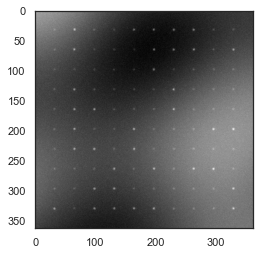

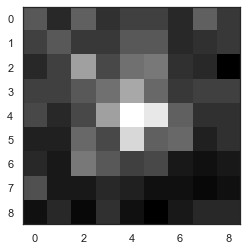

In [18]:
n = 0; wdth = 4
plt.imshow(pic4, cmap = 'gray'); plt.show()
plt.imshow(pic4[locs[n,0]-wdth:locs[n,0]+wdth+1, locs[n,1]-wdth:locs[n,1]+wdth+1], cmap = 'gray');

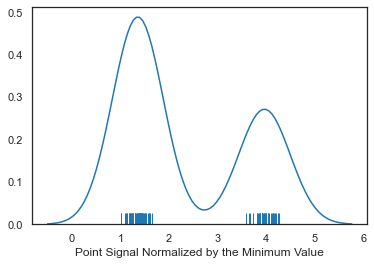

In [19]:
quant_dist(pic4,locs,wdth = 2,sub = True)
plt.savefig(figfile+"quant_dist_dim_hard.png",dpi = 300)

# 4.5 Localization

In [20]:
def local_centre(pic,locs,wdth = 5.0,sub = False,stdev = 10,suppress = False):
    if sub == True:
        bkg = ski.filters.gaussian(pic,stdev)
        pic = pic-bkg
    x0 = np.zeros(np.shape(locs)[0]); x_dev = np.zeros(np.shape(locs)[0])
    y0 = np.zeros(np.shape(locs)[0]); y_dev = np.zeros(np.shape(locs)[0])
    for i,_ in enumerate(locs):
        _,x0[i],y0[i],_,_,_ = anl.gauss2_fit_MLE(pic[locs[i,0]-wdth:locs[i,0]+wdth+1, 
                                                     locs[i,1]-wdth:locs[i,1]+wdth+1], suppress = suppress)
        x_dev[i] = (x0[i]-wdth)*100.0; x0[i] += locs[i,0]-wdth
        y_dev[i] = (y0[i]-wdth)*100.0; y0[i] += locs[i,1]-wdth
    return x0,y0,x_dev,y_dev

Import true locations.

In [21]:
devs = pd.read_csv('Images/emitters1_positions.csv',names=['x_dev_tr', 'y_dev_tr'])

In [22]:
x0,y0,x_dev,y_dev = local_centre(pic,locs,wdth = 4,suppress = True)
devs['x_dev'] = x_dev; devs['y_dev'] = y_dev

In [23]:
def plotter(devs, name):
    plt.figure(figsize = (5,5))
    x_lin = np.arange(np.min(devs['y_dev']),np.max(devs['y_dev']))
    y_lin = x_lin
    plt.plot(devs['x_dev_tr'],devs['x_dev'],'o',alpha = 0.5)
    plt.plot(devs['y_dev_tr'],devs['y_dev'],'o',alpha = 0.5)
    plt.plot(x_lin,y_lin,'--',color = 'indigo',alpha = 0.5)
    plt.xlabel('$true\ values$'); plt.ylabel('$calculated\ values$')
    plt.legend(['$x$','$y$','$unity\ line$'])
    plt.savefig(figfile+name, dpi = 300);

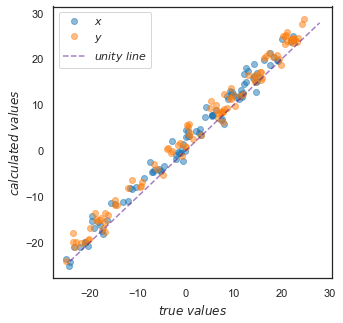

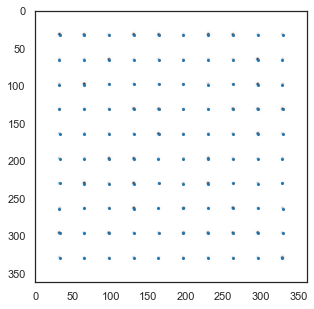

In [24]:
plotter(devs,"localized_quant_bright_easy_true_compare.png")
plt.figure(figsize = (5,5))
plt.imshow(pic, cmap = 'gray_r')
plt.plot(x0,y0,'o',markersize = 2)
plt.savefig(figfile+"localized_quant_bright_easy.png", dpi = 300)

In [25]:
x0,y0,x_dev,y_dev = local_centre(pic3,locs,wdth = 4,suppress = True)
devs['x_dev'] = x_dev; devs['y_dev'] = y_dev

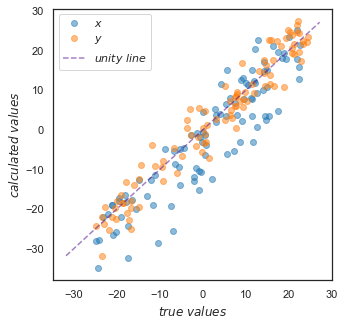

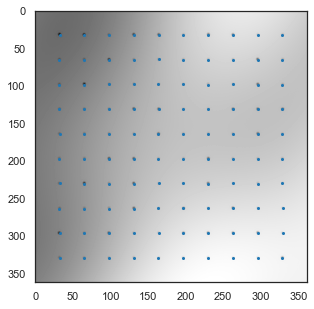

In [26]:
plotter(devs,"localized_quant_bright_hard_true_compare.png")
plt.figure(figsize = (5,5))
plt.imshow(pic3, cmap = 'gray_r')
plt.plot(x0,y0,'o',markersize = 2)
plt.savefig(figfile+"localized_quant_bright_hard.png", dpi = 300)

In [27]:
devs = pd.read_csv('Images/emitters2_positions.csv',names=['x_dev_tr', 'y_dev_tr'])

In [28]:
x0,y0,x_dev,y_dev = local_centre(pic2,locs,wdth = 4,suppress = True)
devs['x_dev'] = x_dev; devs['y_dev'] = y_dev

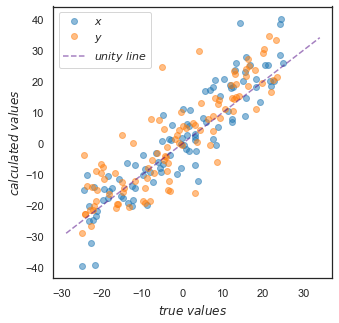

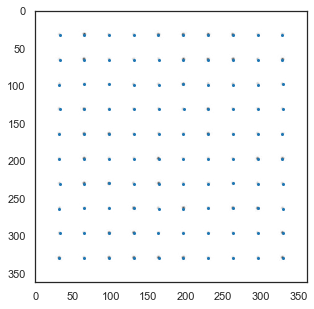

In [29]:
plotter(devs,"localized_quant_dim_easy_true_compare.png")
plt.figure(figsize = (5,5))
plt.imshow(pic2, cmap = 'gray_r')
plt.plot(x0,y0,'o',markersize = 2)
plt.savefig(figfile+"localized_quant_dim_easy.png", dpi = 300)

In [30]:
x0,y0,x_dev,y_dev = local_centre(pic4,locs,wdth = 4,suppress = True)
devs['x_dev'] = x_dev; devs['y_dev'] = y_dev

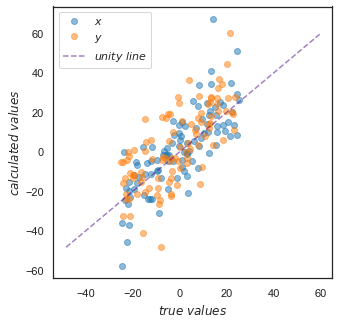

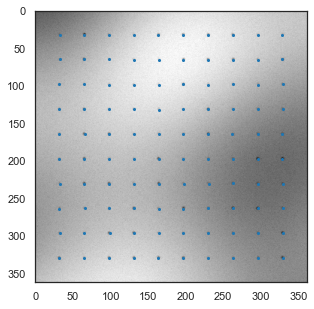

In [31]:
plotter(devs,"localized_quant_dim_hard_compare.png")
plt.figure(figsize = (5,5))
plt.imshow(pic4, cmap = 'gray_r')
plt.plot(x0,y0,'o',markersize = 2)
plt.savefig(figfile+"localized_quant_dim_hard.png", dpi = 300)